# Day 2: LangChain vs. LangGraph - The Self-Correcting AI Researcher

**Objective:** To understand the practical differences between a standard `AgentExecutor` and `LangGraph` for building complex, stateful AI agents.

In this notebook, we will attempt to build an agent with a crucial capability: **self-correction**. The agent's task is to research a topic, but with a twist. It must:
1. Perform an initial web search.
2. **Analyze** its own search results to see if they are good enough.
3. If the results are poor, it must **rewrite** its search query and try again.
4. Only when it has sufficient information should it provide a final answer.

This cyclical, self-evaluating behavior is a hallmark of more advanced, reliable agents. We will see how a standard agent struggles with this task and how LangGraph is explicitly designed to solve it.

## 1. Setup and Dependencies

First, let's install the necessary libraries. We will use `ddgs` for DuckDuckGo search as the older package is deprecated. Then we'll import our modules and set up the environment. Make sure you have a `.env` file in the same directory with your `OPENAI_API_KEY`, or set it up as a secret in your Colab environment.

In [1]:
pip install -U langchain langchain-openai langgraph langchain_community ddgs python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.1/476.1 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing ins

In [5]:
import os
from dotenv import load_dotenv

dotenv_path = os.path.expanduser("dev.env")
load_dotenv(dotenv_path, override=True)

print("Dependencies installed and environment loaded.")

Dependencies installed and environment loaded.


---

## Part 1: The LangChain Agent Attempt (The Brittle Approach)

Here, we'll try to force a standard `AgentExecutor` to perform the self-correction loop by cramming all the logic into a complex prompt. We are essentially *telling* the agent to follow our steps, but we cannot *enforce* it.

**Hypothesis:** The agent will likely struggle to follow the cyclical instructions. It is heavily biased towards moving forward to a `Final Answer` and may ignore the command to loop back, especially if the initial results are weak.

### 1.1: Define Tools and LLM

In [6]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun

# Tool: The agent only has one tool, a web search.
search_tool = DuckDuckGoSearchRun()
tools = [search_tool]

# LLM: Using a powerful model to give it the best chance.
llm = ChatOpenAI(model="gpt-4o", temperature=0)

### 1.2: The Complex Prompt

This is the core of the attempt. We modify a standard ReAct prompt to include a detailed, multi-step procedure. The agent's ability to follow these instructions is entirely dependent on the LLM's interpretation, making it unreliable.

In [7]:
!python -V

Python 3.12.12


In [8]:
pip show langchain langchain-openai langgraph langchain_community ddgs python-dotenv

Name: langchain
Version: 1.2.0
Summary: Building applications with LLMs through composability
Home-page: https://docs.langchain.com/
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.12/dist-packages
Requires: langchain-core, langgraph, pydantic
Required-by: 
---
Name: langchain-openai
Version: 1.1.4
Summary: An integration package connecting OpenAI and LangChain
Home-page: https://docs.langchain.com/oss/python/integrations/providers/openai
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.12/dist-packages
Requires: langchain-core, openai, tiktoken
Required-by: 
---
Name: langgraph
Version: 1.0.5
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://docs.langchain.com/oss/python/langgraph/overview
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, pydantic, xxhash
Required-by: langchain
---
Name: langchai

### 1.3: Create and Run the Agent

Now we assemble the agent and run it. Observe the `verbose` output carefully to see if it follows our instructions. The final output will be rendered as Markdown.

In [9]:
from IPython.display import display, Markdown

# Let's run it with a niche topic that likely requires re-searching
topic = "The impact of LangGraph on multi-agent system reliability compared to traditional agent loops"

### 1.4: Analysis of the LangChain Agent's Performance

You will likely observe that the agent performs one search and then immediately proceeds to a `Final Answer`, even if the results are clearly insufficient. It fails to follow the instruction to loop back.

**The core problem is the lack of control.** We are *suggesting* a workflow in the prompt, but the `AgentExecutor`'s fundamental design doesn't support enforcing this kind of cycle. This is a classic example of a workflow that is **not feasible** to implement reliably with this architecture.

---

## Part 2: The LangGraph Solution (The Robust Approach)

Now, let's build the same agent using LangGraph. Instead of a complex prompt, we will define our workflow as an explicit graph of nodes and edges.

**Hypothesis:** The LangGraph implementation will reliably execute the self-correction loop every time it's needed, because the flow is enforced by code, not suggested by a prompt.

### 2.1: Define the State

The `State` is a central concept in LangGraph. It's a single object (in this case, a dictionary) that gets passed between all the nodes in our graph. Each node can read from it and write to it, allowing us to track our progress through the workflow.

In [10]:
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    """Represents the state of our research agent."""
    topic: str
    messages: Annotated[List[BaseMessage], lambda x, y: x + y]
    search_results: str | None
    retries: int

### 2.2: Define the Graph Nodes

Nodes are the fundamental building blocks of a LangGraph workflow. Each node is a simple Python function that receives the current `state` and returns a dictionary containing the values to update in the state.

#### Node 1: `initial_search_node`
This node performs the first web search based on the initial topic and initializes our retry counter.

In [25]:
def initial_search_node(state: AgentState):
    print("---NODE: Initial Search---")
    search_results = search_tool.run(state['topic'])
    return {"search_results": search_results, "retries": 0}

#### Node 2: `analyze_results_node` (Improved Logic)

This node uses the LLM to act as a judge. **This is the improved version.** It now explicitly checks if the search tool failed. If so, it immediately decides the results are `insufficient`, making the agent more robust.

In [26]:
from langchain_core.messages import SystemMessage

def analyze_results_node(state: AgentState):
    print("---NODE: Analyze Results---")
    search_results = state['search_results']

    # Check for a failed search result explicitly.
    if not search_results or "No good DuckDuckGo Search Result was found" in search_results:
        print("Analysis Decision: Search failed, results are insufficient.")
        return {"messages": [SystemMessage(content="Analysis: insufficient")]}

    analysis_prompt = f"""You are an expert researcher. Analyze these search results for the topic '{state['topic']}' and determine if they are sufficient to write a comprehensive answer. Respond with only 'sufficient' or 'insufficient'.\n\nResults:\n{state['search_results']}"""
    response = llm.invoke(analysis_prompt)
    decision = response.content.strip().lower()
    print(f"Analysis Decision: {decision}")
    return {"messages": [SystemMessage(content=f"Analysis: {decision}")]}

#### Node 3: `rewrite_query_node`

This node is only called if the analysis fails. It uses the LLM to generate a *better* search query and then executes the search again, updating the state with the new results.

In [13]:
def rewrite_query_node(state: AgentState):
    print("---NODE: Rewrite Query---")
    retries = state['retries']
    rewrite_prompt = f"""You are a search expert. Your search for '{state['topic']}' was insufficient. Rewrite it into a better, more specific search query."""
    new_query = llm.invoke(rewrite_prompt).content.strip()
    print(f"New Query: {new_query}")
    search_results = search_tool.run(new_query)
    return {"search_results": search_results, "retries": retries + 1}

#### Node 4: `final_response_node`

This is the final step, only reached when the results are deemed sufficient. It synthesizes all the gathered information into a comprehensive answer.

In [14]:
def final_response_node(state: AgentState):
    print("---NODE: Final Response---")
    response_prompt = f"""Based on the following search results, provide a detailed answer to the topic: '{state['topic']}'.\n\nResults:\n{state['search_results']}"""
    final_response = llm.invoke(response_prompt).content
    return {"messages": [SystemMessage(content=final_response)]}

### 2.3: Define the Edges and Assemble the Graph

Edges connect our nodes. A **conditional edge** is a special type of edge that uses a function to decide which node to go to next based on the current state. This is how we create our self-correction loop.

In [27]:
from langgraph.graph import StateGraph, END

# This function is our conditional edge.
def should_continue_edge(state: AgentState):
    # First, check for the max retries condition to prevent infinite loops
    if state['retries'] > 20:
        print("---DECISION: Max retries reached, ending.---")
        return "end"

    # Check the analysis message in the state
    last_message = state['messages'][-1].content
    if "insufficient" in last_message:
        print("---DECISION: Results are insufficient, rewriting query.---")
        return "rewrite"
    else:
        print("---DECISION: Results are sufficient, generating final response.---")
        return "end"

# Assemble the graph
workflow = StateGraph(AgentState)
workflow.add_node("initial_search", initial_search_node)
workflow.add_node("analyze_results", analyze_results_node)
workflow.add_node("rewrite_query", rewrite_query_node)
workflow.add_node("final_response", final_response_node)

workflow.set_entry_point("initial_search")
workflow.add_edge("initial_search", "analyze_results")
workflow.add_edge("rewrite_query", "analyze_results") # The crucial loop!
workflow.add_conditional_edges(
    "analyze_results",
    should_continue_edge,
    {"rewrite": "rewrite_query", "end": "final_response"} # This dictionary maps the edge function's return value to a node name
)
workflow.add_edge("final_response", END)

app = workflow.compile()
print("Graph compiled successfully!")

Graph compiled successfully!


### 2.4: Visualize the Graph

One of the best features of LangGraph is the ability to visualize your agent's structure. This makes it incredibly easy to understand and debug the flow.

**Note:** This requires `graphviz` and its development libraries to be installed. The command below handles this for Debian-based systems like Google Colab.

In [28]:
pip install -q pygraphviz

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pygraphviz)


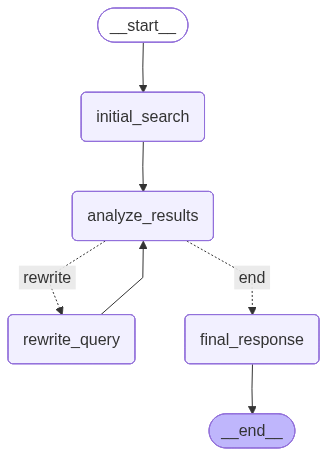

In [29]:
# Install system dependencies for visualization
#!sudo apt-get -qq install -y graphviz libgraphviz-dev


from IPython.display import Image, display

try:
    # Generate the visualization
    graph_image = app.get_graph().draw_mermaid_png()
    display(Image(graph_image))
except Exception as e:
    print(f"Error generating visualization: {e}")
    print("Please ensure graphviz and its development libraries are installed correctly.")

### 2.5: Run the Graph and Observe the State

Now we run our compiled graph. We will `stream` the events to inspect the **interim state** after each node runs. We also pass a `config` dictionary to set a higher recursion limit, preventing the `GraphRecursionError`.

In [30]:
initial_input = {"topic": topic, "messages": []}
config = {"recursion_limit": 50} # Set a higher limit for safety

print("--- Running LangGraph App ---")
for i, step in enumerate(app.stream(initial_input, config=config)):
    # The 'step' object contains the output of the node that just ran
    node_name = list(step.keys())[0]
    node_output = step[node_name]

    print(f"\n--- STEP {i+1}: Executed Node '{node_name}' ---")
    print("Output of this node:")
    print(node_output)
    print("-" * 60)



--- Running LangGraph App ---
---NODE: Initial Search---

--- STEP 1: Executed Node 'initial_search' ---
Output of this node:
{'search_results': '4 days ago · Why Multi-Agent Systems Break Without Observability LangGraph makes it possible to model reasoning as a graph: agents , tools, validators, loops , and decision points are explicit. 1 day ago · Ensuring the reliability of agent architectures and effectively identifying problematic agents when failures occur are crucial challenges in multi-agent systems (MAS). Advances in large language models (LLMs) have established LLM-based agents as a major branch of MAS, enabling major breakthroughs in complex problem solving and world modeling. Apr 4, 2025 · In this article, we’ll explore how to implement LangGraph in a production-grade, multi - agent system powered by OpenAI models, vector databases, and custom tool integrations. Aug 5, 2025 · Explore how to design memory-aware, production-grade multi - agent systems using LangGraph and Crew

In [38]:
node_output['messages'][-1].content

"LangGraph is a novel approach to enhancing the reliability of multi-agent systems (MAS) by providing a structured framework for modeling agent interactions and decision-making processes. Compared to traditional agent loops, LangGraph offers several advantages that contribute to improved system reliability.\n\n### Key Features of LangGraph\n\n1. **Graph-Based Modeling**: LangGraph models reasoning as a graph, where agents, tools, validators, loops, and decision points are explicitly represented. This visualization allows for a clearer understanding of the interactions and dependencies within the system, making it easier to identify potential points of failure.\n\n2. **Enhanced Observability**: One of the primary reasons multi-agent systems fail is the lack of observability. LangGraph addresses this by making the internal processes of agents more transparent. This transparency helps in monitoring agent behavior and diagnosing issues when they arise.\n\n3. **Integration with Large Langua

In [41]:
display(Markdown(node_output['messages'][-1].content))

LangGraph is a novel approach to enhancing the reliability of multi-agent systems (MAS) by providing a structured framework for modeling agent interactions and decision-making processes. Compared to traditional agent loops, LangGraph offers several advantages that contribute to improved system reliability.

### Key Features of LangGraph

1. **Graph-Based Modeling**: LangGraph models reasoning as a graph, where agents, tools, validators, loops, and decision points are explicitly represented. This visualization allows for a clearer understanding of the interactions and dependencies within the system, making it easier to identify potential points of failure.

2. **Enhanced Observability**: One of the primary reasons multi-agent systems fail is the lack of observability. LangGraph addresses this by making the internal processes of agents more transparent. This transparency helps in monitoring agent behavior and diagnosing issues when they arise.

3. **Integration with Large Language Models (LLMs)**: LangGraph leverages advances in LLMs, which have become a significant component of MAS. These models enhance the system's ability to solve complex problems and model the world, thus increasing the overall robustness and reliability of the system.

4. **Task Routing and Agent Handoffs**: LangGraph supports sophisticated task routing and agent handoffs, which are crucial for maintaining system reliability. By ensuring that tasks are efficiently distributed and that agents can seamlessly take over tasks from one another, LangGraph minimizes the risk of system breakdowns.

5. **Memory-Aware Design**: The framework is designed to be memory-aware, which is essential for managing the state and context of interactions in a multi-agent environment. This feature helps in maintaining consistency and reliability across agent operations.

### Comparison with Traditional Agent Loops

- **Complexity Management**: Traditional agent loops often struggle with managing the complexity of interactions in a multi-agent system. LangGraph's graph-based approach simplifies this by providing a clear map of interactions, making it easier to manage and optimize.

- **Failure Identification**: In traditional systems, identifying problematic agents or loops can be challenging due to the lack of explicit modeling. LangGraph's explicit representation of decision points and validators aids in quickly pinpointing failures and addressing them.

- **Scalability**: LangGraph is designed to be scalable, accommodating the integration of various tools and custom solutions. This scalability is often limited in traditional agent loops, which may not easily adapt to the addition of new components or changes in the system.

- **Real-World Application**: LangGraph has been implemented in production-grade systems, demonstrating its practical applicability and effectiveness in real-world scenarios. Traditional loops may require significant adaptation to achieve similar levels of reliability and performance.

### Conclusion

LangGraph significantly enhances the reliability of multi-agent systems by providing a structured, transparent, and scalable framework for modeling agent interactions. Its integration with LLMs and focus on observability and task management make it a superior choice compared to traditional agent loops, particularly in complex and dynamic environments. As multi-agent systems continue to evolve, LangGraph offers a robust foundation for developing reliable and efficient agent architectures.

### 2.6: Analysis of the LangGraph Performance

As you can see from the output, the flow is explicit and reliable. The graph moves from node to node, the conditional edge correctly routes the flow back for a retry, and the state is updated predictably at each step. This is the power of defining your agent's logic as code rather than as a prompt.


## Conclusion: The Right Tool for the Job

- **LangChain `AgentExecutor`:** An excellent tool for rapid prototyping and building agents where the workflow is relatively linear (Tool A -> Tool B -> Answer). It's the "automatic transmission" for getting started quickly.

- **LangGraph:** The essential tool for building production-grade, reliable agents that require complex, stateful logic. It provides the "manual transmission" needed for fine-grained control over cycles, retries, and branching, which is impossible to achieve reliably with a standard agent.